# Classification. Linear models and KNN

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Part 1: Titanic survival prediction

### Dataset

Read the description here: https://www.kaggle.com/c/titanic/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/titanic/overview/evaluation.  

In [3]:
data=pd.read_csv("train.csv").set_index('PassengerId')

In [4]:
df=data[['Survived','Pclass','Sex','Age','SibSp','Parch']].copy()

In [5]:
data_test=pd.read_csv("test.csv").set_index('PassengerId')

### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

Let's calculate females and males on train and joined (train+test) data sets

In [6]:
df_full=pd.concat([df[['Pclass','Sex','Age']], data_test[['Pclass','Sex','Age']]])
female_full_size,male_full_size=df_full.groupby("Sex").size()
female_train_size,male_train_size=df.groupby("Sex").size()
#full_size
print('full data set female ',female_full_size,' male ' ,male_full_size)
#train_size
print('train data set female ',female_train_size,' male ' ,male_train_size)

full data set female  466  male  843
train data set female  314  male  577


Let's plot mosaic and violin plot to have a look on relationship between the gender and the survival. As we found below there are more survivors in female group then drowned, when in men group it is opposite

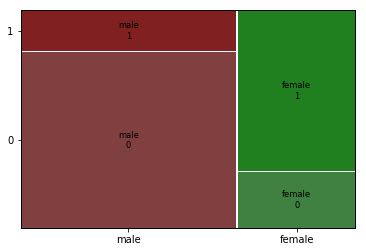

In [7]:
#https://www.statsmodels.org/stable/generated/statsmodels.graphics.mosaicplot.mosaic.html
mosaic(df,["Sex","Survived"], statistic=False)
plt.show()

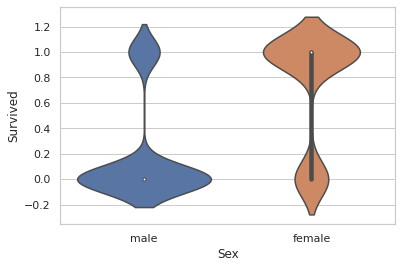

In [8]:
sns.set_theme(style="whitegrid")
ax = sns.violinplot(x=df["Sex"], y=data["Survived"], data=df)

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

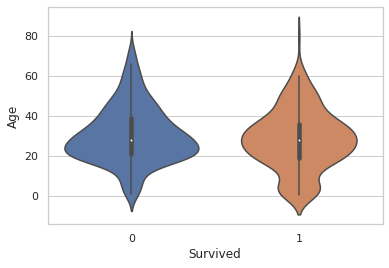

In [9]:
ax2 = sns.violinplot(y=data["Age"], x=df["Survived"], data=df)

Survived without Age:
0    125
1     52
Name: Survived, dtype: int64
male_age_survived_median, avg  28.0 27.276021505376345
male_age_deceased_median, avg  29.0 31.618055555555557
female_age_survived_median, avg  28.0 28.84771573604061
female_age_deceased_median, avg  24.5 25.046875


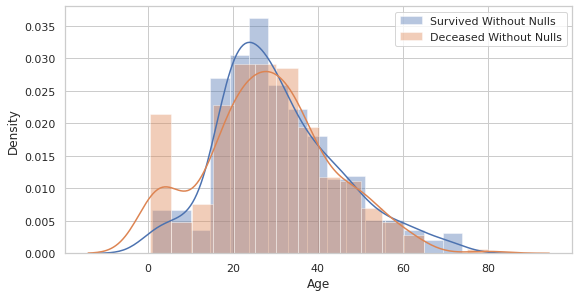

In [10]:
fig = plt.figure(figsize=(20, 10))
fig1 = fig.add_subplot(221)
g = sns.distplot(data[~data.Age.isnull() & data.Survived==0 ].Age, label='Survived Without Nulls')
g = sns.distplot(data[~data.Age.isnull() & data.Survived==1 ].Age, label='Deceased Without Nulls')
plt.legend(loc='upper right')
print('Survived without Age:')
print(data[data.Age.isnull()].Survived.value_counts())
female_age_survived_median,male_age_survived_median=df[(df['Survived']==1)].groupby("Sex")['Age'].median()
female_age_deceased_median,male_age_deceased_median=df[(df['Survived']==0)].groupby("Sex")['Age'].median()
female_age_survived_avg,male_age_survived_avg=df[(df['Survived']==1)].groupby("Sex")['Age'].mean()
female_age_deceased_avg,male_age_deceased_avg=df[(df['Survived']==0)].groupby("Sex")['Age'].mean()
print('male_age_survived_median, avg ', male_age_survived_median,male_age_survived_avg)
print('male_age_deceased_median, avg ', male_age_deceased_median,male_age_deceased_avg)
print('female_age_survived_median, avg ',female_age_survived_median,female_age_survived_avg)
print('female_age_deceased_median, avg ',female_age_deceased_median,female_age_deceased_avg)

Age distributions are not very differ for survived and deceased passengers, as we not concidering sex feature hear.

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

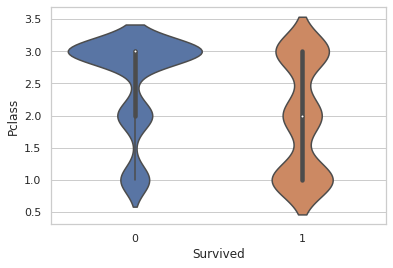

In [11]:
ax2 = sns.violinplot(y=data["Pclass"], x=df["Survived"], data=df)

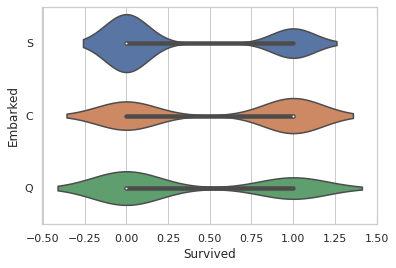

In [12]:
ax3 = sns.violinplot(y=data["Embarked"], x=df["Survived"], data=df)

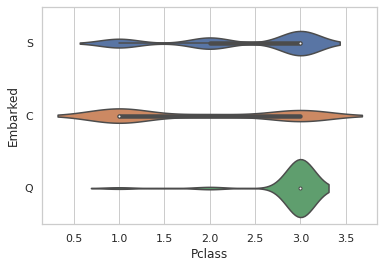

In [13]:
ax3 = sns.violinplot(y=data["Embarked"], x=df["Pclass"], data=df)

As we found out from plots the most safe class was 1st, the most dangerous 3rd. It was expected as service team was more oriented on more powerfull category. As a result embarked C with had more 1st class passengers had more survivors, where S and Q less. Another reasons for embarked - is placement incide ship and single/family passengers. As wee found embarked S had less proportion of survivors than Q, when Q had bigger proportion of 3 class passengers.

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [14]:
from tabulate import tabulate
top = 10
print(tabulate(
    sorted(list(zip(df.columns, df.isnull().sum(), df.isnull().sum() / df.shape[0] * 100)), key=lambda x: -x[2])[:top], 
    headers=['col_name', 'null_cnt', 'null_perc']))

col_name      null_cnt    null_perc
----------  ----------  -----------
Age                177      19.8653
Survived             0       0
Pclass               0       0
Sex                  0       0
SibSp                0       0
Parch                0       0


Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

I will find median of age for 'Pclass','Sex' from full dataset and will replace nulls in train and test with it

In [15]:
df_full=pd.concat([df[['Pclass','Sex','Age']], data_test[['Pclass','Sex','Age']]])

In [16]:
for i in range(1,4,1):
    female_age,male_age=df_full[(df_full['Pclass']==i)].groupby("Sex")['Age'].median()
    df.loc[(df['Age'].isnull()) & (df['Pclass']==i) & (df['Sex']=='male'),'Age'] = male_age
    df.loc[(df['Age'].isnull()) & (df['Pclass']==i) & (df['Sex']=='female'),'Age'] = female_age
    data_test.loc[(data_test['Age'].isnull()) & (data_test['Pclass']==i) & (data_test['Sex']=='male'),'Age'] = male_age
    data_test.loc[(data_test['Age'].isnull()) & (data_test['Pclass']==i) & (data_test['Sex']=='female'),'Age'] = female_age

Check of replacement

In [17]:
from tabulate import tabulate
top = 10
print(tabulate(
    sorted(list(zip(df.columns, df.isnull().sum(), df.isnull().sum() / df.shape[0] * 100)), key=lambda x: -x[2])[:top], 
    headers=['col_name', 'null_cnt', 'null_perc']))

col_name      null_cnt    null_perc
----------  ----------  -----------
Survived             0            0
Pclass               0            0
Sex                  0            0
Age                  0            0
SibSp                0            0
Parch                0            0


Arranging

Tried to make bins and categories from Age. But later rejected

In [18]:
# from sklearn.preprocessing import KBinsDiscretizer
# transformer=KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')
# df['Cluster_age'] =  transformer.fit_transform(df.Age.values.reshape(-1, 1))
# data_test['Cluster_age'] =  transformer.transform(data_test.Age.values.reshape(-1, 1))

Dummy columns introduction

In [19]:
dummy_cols=["Sex","Pclass"]

In [20]:
df["Sex_cat"]=df["Sex"]

In [21]:
df["Pclass_cat"]=df["Pclass"]

In [22]:
df = pd.get_dummies(df, columns=dummy_cols, drop_first=True)

In [23]:
del data_test['Name']
del data_test['Ticket']
del data_test['Cabin']
del data_test['Embarked']

In [24]:
data_test=pd.get_dummies(data_test, columns=dummy_cols, drop_first=True)

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [25]:
# numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
list_all_col=df.columns.values
target="Survived"
drop_col=['Pclass_cat','Sex_cat']
# df.select_dtypes(include=numerics).columns.values
list_X_col=np.setxor1d(list_all_col,target)
list_X_col=np.setxor1d(list_X_col,drop_col)

Chosen columns

In [26]:
list_X_col

array(['Age', 'Parch', 'Pclass_2', 'Pclass_3', 'Sex_male', 'SibSp'],
      dtype=object)

In [27]:
X_train =df[list_X_col]

y_train=df[target]

In [39]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SequentialFeatureSelector

main_model = LogisticRegression(solver='liblinear',penalty='l1') #, penalty='l2',max_iter=12000
## Have tried different variants -with scalers and without (when Age was in dummies)
# scaler=StandardScaler()
# scaler=MinMaxScaler()


feature_names = X_train.columns
selection_model = KNeighborsClassifier(n_neighbors=4)
selector = SequentialFeatureSelector(selection_model, n_features_to_select=feature_names.size-3)
selector.fit(X_train, y_train)
n_features_to_select=feature_names[selector.get_support()].tolist()
print("Features selected by forward sequential selection: "
      f"{feature_names[selector.get_support()].tolist()}")

#tried with scaler, selector, differnt combinations
pipe_scale = make_pipeline( main_model) #scaler,main_model, selector

Features selected by forward sequential selection: ['Pclass_2', 'Pclass_3', 'Sex_male']


In [30]:
X_test=data_test[list_X_col]

In [32]:
model2=cross_validate(pipe_scale,X_train,y_train ,scoring='accuracy', cv=3,return_estimator=True)

In [33]:
model=(model2['estimator'])[2]

In [34]:
predictions = model.predict(X_test)

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

Load the test set and make the predictions. Submit them to kaggle and see the results :)
Select the best model, load the test set and make the predictions. Submit them to kaggle.

**Note**. X points will depend on your kaggle leaderboard score.
$$ f(score) = 0.5, \ \ 0.79 \leq score < 0.81,$$
$$ f(score) = 1.0, \ \ 0.81 \leq score < 0.83,$$ 
$$ f(score) = 2.5, \ \ 0.83 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

In [40]:
output = pd.DataFrame({'PassengerId': X_test.index, 'Survived': predictions})
output.to_csv('my_submission20.csv', index=False)

max score on kaggle was 0.77033. With current file it should be 0.76555